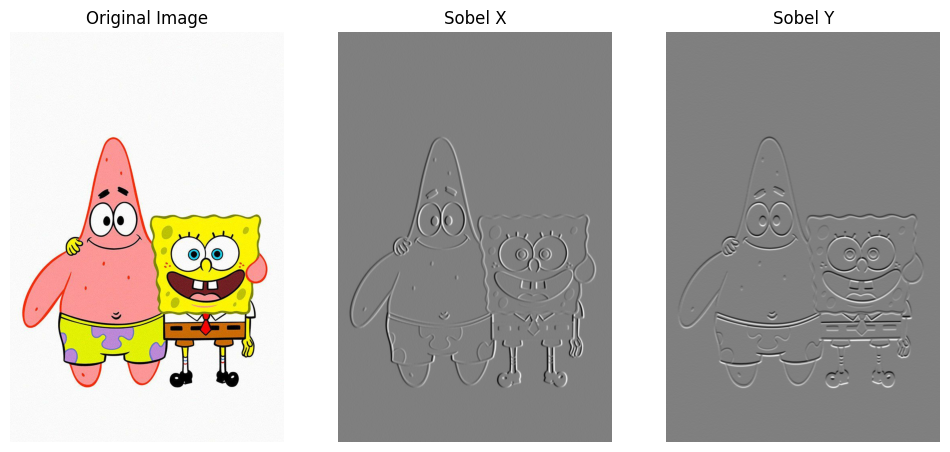

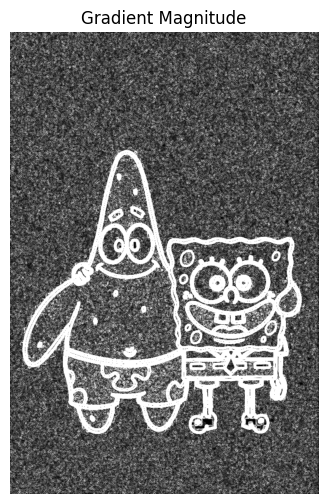

In [6]:
!pip install opencv-python-headless
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files




img = cv2.imread('/content/spongebob.jpg')


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


blurred = cv2.GaussianBlur(gray, (3, 3), 0)


sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)


magnitude = cv2.magnitude(sobelx, sobely)


magnitude = cv2.convertScaleAbs(magnitude)


sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)


magnitude = cv2.magnitude(sobelx, sobely)


magnitude = cv2.convertScaleAbs(magnitude)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')
plt.axis('off')

plt.figure(figsize=(6, 6))
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.show()


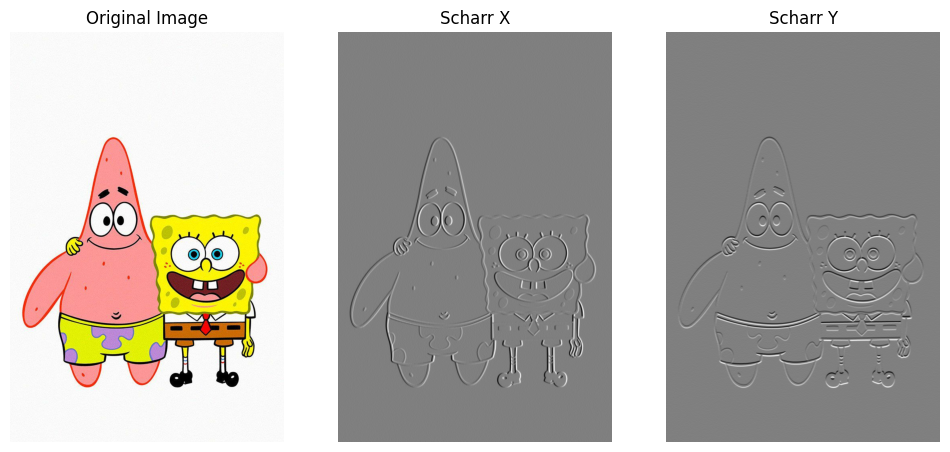

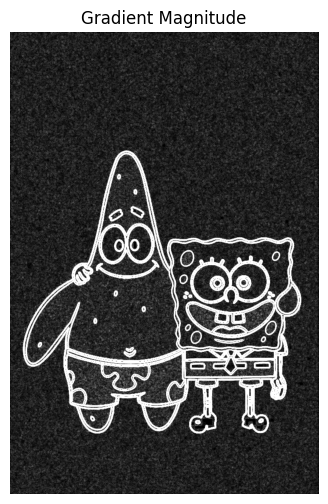

In [7]:
scharrx = cv2.Scharr(blurred, cv2.CV_64F, 1, 0)
scharry = cv2.Scharr(blurred, cv2.CV_64F, 0, 1)

magnitude = cv2.magnitude(scharrx, scharry)


magnitude = cv2.convertScaleAbs(magnitude)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(scharrx, cmap='gray')
plt.title('Scharr X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(scharry, cmap='gray')
plt.title('Scharr Y')
plt.axis('off')

plt.figure(figsize=(6, 6))
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.show()

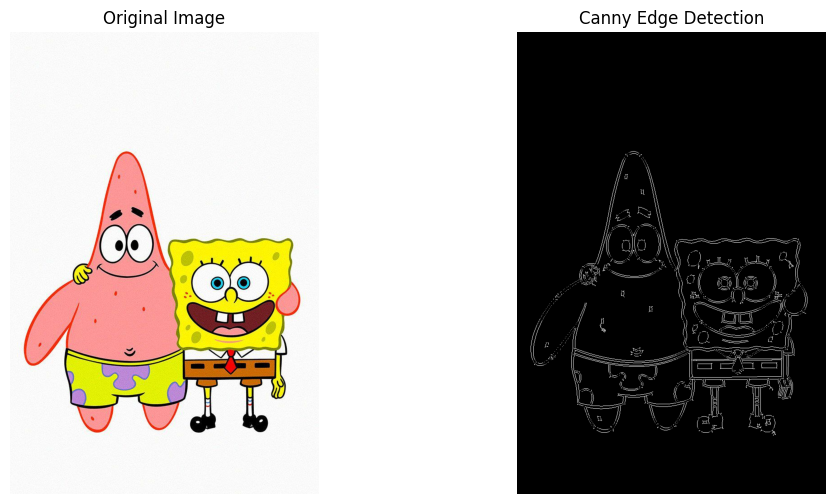

In [12]:
Gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
Gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.hypot(Gx, Gy)
magnitude = magnitude / magnitude.max() * 255
theta = np.arctan2(Gy, Gx)

def non_max_suppression(magnitude, theta):
    M, N = magnitude.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255


                if (0 <= angle[i,j] < 25) or (160 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]

                elif (22.5 <= angle[i,j] < 70):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]

                elif (67.5 <= angle[i,j] < 120):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]

                elif (112.5 <= angle[i,j] < 190):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    Z[i,j] = magnitude[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

nms = non_max_suppression(magnitude, theta)


def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

thresholded, weak, strong = threshold(nms)


def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i,j] = strong
                    else:
                        img[i,j] = 0
                except IndexError as e:
                    pass
    return img

edges = hysteresis(thresholded, weak, strong)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

plt.show()